# UNSEEN fidelity testing for HydroTas 2020-2021 workplan:
- rainfall and surface temp over Melbourne and Tasmania region

In [1]:
sys.path.insert(0, '/OSM/CBR/OA_DCFP/work/squ027/software/xhistogram')

import xks
import numpy as np
import xarray as xr
import myfuncs as my
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from xhistogram.xarray import histogram as xhist

import warnings
warnings.filterwarnings("ignore")

# Cluster for bootstrapping only

In [2]:
cluster = SLURMCluster(
    walltime='02:00:00', 
    cores=6, 
    memory='36GB', 
    job_extra=['--qos="express"'])

In [3]:
cluster.scale(jobs=6)
client = Client(cluster)
client

Client Scheduler: tcp://10.141.1.184:37495 Dashboard: http://10.141.1.184:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Parameters

In [4]:
REGION = 'TAS'
VARIABLE = 'precip'
TEST_PERIOD = slice('1990-01-01', '2019-12-31')

In [5]:
def max_month_to_year(a, axis):
    years = np.floor(np.max(a, axis) / 12).astype(int)
    assert len(years) == len(set(years)), 'Not unique'
    return years


def resample_forecasts_monthly(ds, n_months, end_month, method='sum', 
                               lead_time_func='max'):
    """ Resample forecasts to a set of months for each year"""
    def _resample_grouped_monthly_forecasts(ds, method):
        month = np.unique(ds.init_date.dt.month)
        assert len(month) == 1
        start_month = (end_month - (n_months-1)) % 12
        i_start = (start_month - month[0]) % 12
        rs = ds.isel(lead_time=slice(i_start, None)).coarsen(
            lead_time=n_months, boundary='trim',
            coord_func={'lead_time': lead_time_func, 
                        'time': 'max'})
        if method == 'sum':
            return rs.sum()
        elif method == 'mean':
            return rs.mean()
        else:
            raise InputError('Unrecognised method')
    
    rs = ds.groupby('init_date.month').map(
        _resample_grouped_monthly_forecasts, method=method)
    rs['time'].attrs = ds['time'].attrs
    return rs

# Stack the data

In [105]:
obsv = my.open_zarr(f'data/awap_{VARIABLE}_{REGION}_ts.zarr.zip').compute()
fcst = my.open_zarr(f'data/f6_{VARIABLE}_{REGION}.zarr.zip').compute()

In [106]:
fcst_acc = resample_forecasts_monthly(
    fcst, n_months=12, end_month=12,
    lead_time_func=max_month_to_year)
obsv_acc = obsv.resample(time='A-DEC').sum()

In [107]:
fcst_super = my.mask_time_period(
    fcst_acc, TEST_PERIOD).stack(sample=['init_date','ensemble'])
obsv_super = my.mask_time_period(
    obsv_acc, TEST_PERIOD).stack(sample=['time'])

# Test the fidelity using a 1D KS test

In [108]:
D, p = xks.ks1d2s(obsv_super, fcst_super, sample_dim='sample')

### What about with boostrapping?
Note that Nans in the fcst dataset mean that the sample size of the resampled distribution is reduced relative to the sample size of the observations. If we try to increase the sample size to roughly compensate for this, bootstrapping gives similar results to using the scipy p-values

In [110]:
%%time
N_BOOTSTRAPS = 1000
D, _ = xks.ks1d2s(obsv_super, fcst_super, sample_dim='sample')
D_mc, _ = my.n_random_resamples(fcst_super,
                                samples={'sample': (len(obsv_super.sample), 1)}, 
                                n_repeats=N_BOOTSTRAPS,
                                function=xks.ks1d2s,
                                function_kwargs={'ds2': fcst_super, 'sample_dim':'sample'})  
p_mc = (D_mc > D).mean('k')

CPU times: user 12.1 s, sys: 680 ms, total: 12.8 s
Wall time: 1min 2s


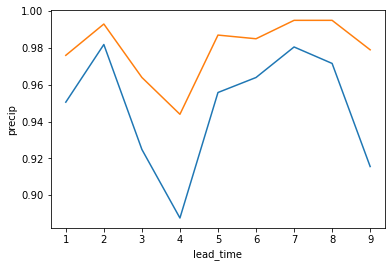

In [111]:
p['precip'].plot()
p_mc['precip'].plot()

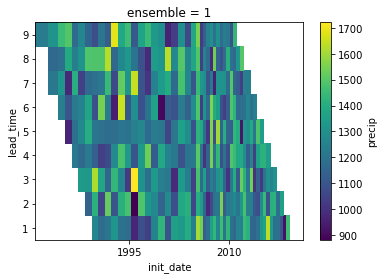

In [100]:
fcst_super.unstack()['precip'].isel(ensemble=0).plot()

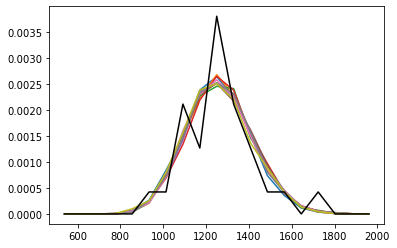

In [104]:
import matplotlib.pyplot as plt
bins = np.linspace(500,2000,20)

for lead in fcst_super.lead_time:
    data = fcst_super['precip'].sel(lead_time=lead).values
    hist, bin_edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, hist)
    
data = obsv_super['precip'].values
hist, bin_edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, color='k')

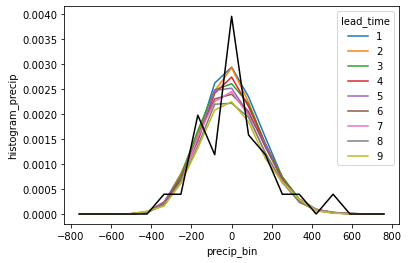

In [21]:
bins = np.linspace(-800,800,20)

fcst_pdf = xhist(fcst_super['precip'], bins=[bins], dim=['sample'], density=True)
obsv_pdf = xhist(obsv_super['precip'], bins=[bins], dim=['sample'], density=True)

fcst_pdf.plot.line(x='precip_bin')
obsv_pdf.plot.line(color='k');

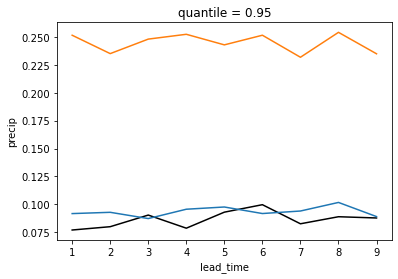

In [21]:
D['precip'].plot(color='k')
D_mc.quantile(0.05, dim='k')['precip'].plot()
D_mc.quantile(0.95, dim='k')['precip'].plot()

In [ ]:
def unseen_bivariate_KS_fidelity(fcst_var1, fcst_var2, obsv_var1, obsv_var2, max_period, 
                                 alpha=5, n_repeats=1000, by_lead=True):
    """ Run KS test to determine whether forecast and observation distributions are consistent
        if alpha == None, returns two Datasets
            KS-statistic comparing the observations to the unseen sample
            n_repeats samples of the KS-statistic comparing random draws from the unseen sample of size equal 
                to the observed sampleto the unseen sample
        else returns single Dataset with
            True where the KS-statistic from the observations is less that the 100-alpha percentile of the resampled 
                distribution
    """

    def _adjust_period(period, obsv, fcst):
        """Adjust the period based on times available in obsv and fcst"""
        period = period.copy()
        adjusted = False
        if obsv.time.min() > period[0]:
            period[0] = obsv.time.min().values
            adjusted = True
        if obsv.time.max() < period[1]:
            period[1] = obsv.time.max().values
            adjusted = True
        if fcst.time.min() > period[0]:
            period[0] = fcst.time.min().values
            adjusted = True
        if fcst.time.max() < period[1]:
            period[1] = fcst.time.max().values
            adjusted = True
        if adjusted:
            warnings.warn(f'I adjusted the period to {period}')
        return period

    assert fcst_var1.shape == fcst_var2.shape
    assert obsv_var1.shape == obsv_var2.shape
    if by_lead:
        fcst_var1_stacked = fcst_var1.groupby('init_date.month').map(stack_super_ensemble,
                                                                     **{'period': max_period,
                                                                        'super_ensemble_dims': ('init_date','ensemble')})
        fcst_var2_stacked = fcst_var2.groupby('init_date.month').map(stack_super_ensemble,
                                                                     **{'period': max_period,
                                                                        'super_ensemble_dims': ('init_date','ensemble')})
    else:
        fcst_var1_stacked = stack_super_ensemble(fcst_var1, max_period, 
                                                    super_ensemble_dims=('init_date','ensemble', 'lead_time'))
        fcst_var2_stacked = stack_super_ensemble(fcst_var2, max_period, 
                                                    super_ensemble_dims=('init_date','ensemble', 'lead_time'))
    any_nans = xr.where(fcst_var1_stacked.isnull(), 1, 0).sum().values + xr.where(fcst_var2_stacked.isnull(), 1, 0).sum().values

    fcst_ds = fcst_var1_stacked.to_dataset(name='var1')
    fcst_ds['var2'] = fcst_var2_stacked
    obsv_ds = obsv_var1.to_dataset(name='var1')
    obsv_ds['var2'] = obsv_var2

    if any_nans > 0:
        if by_lead:
            # Not all times are available at all leads - loop over each lead separately
            concat_D = []; concat_Dmc = []
            for lead in fcst_var1_stacked.lead_time:
                fcst_lead = fcst_ds.sel(lead_time=lead).dropna('super_ensemble')
                period = _adjust_period(max_period, obsv_ds, fcst_lead)
                obsv_period = obsv_ds.where((obsv_ds.time >= period[0]) & (obsv_ds.time <= period[1]), drop=True)
                concat_D.append(ks2d2s(obsv_period.rename({'time':'super_ensemble'}), 
                                       fcst_lead, 'super_ensemble'))
                concat_Dmc.append(n_random_resamples(fcst_lead,
                                                     samples={'super_ensemble': (len(obsv_period.time), 1)}, 
                                                     n_repeats=n_repeats,
                                                     function=ks2d2s,
                                                     function_kwargs={'ds2':fcst_lead, 
                                                                      'sample_dim':'super_ensemble'}))
            D = xr.concat(concat_D, dim='lead_time')
            D_mc = xr.concat(concat_Dmc, dim='lead_time')
    else:
        period = _adjust_period(max_period, obsv_ds, fcst_ds)
        obsv_period = obsv_ds.where((obsv_ds.time >= period[0]) & (obsv_ds.time <= period[1]), drop=True)
        D = ks2d2s(obsv_period.rename({'time':'super_ensemble'}), 
                      fcst_ds, 'super_ensemble')
        D_mc = n_random_resamples(fcst_ds,
                                  samples={'super_ensemble': (len(obsv_period.time), 1)}, 
                                  n_repeats=n_repeats,
                                  function=ks2d2s,
                                  function_kwargs={'ds2':fcst_ds, 'sample_dim':'super_ensemble'})  

    if alpha:
        return D < D_mc.quantile(1-alpha/100, dim='k')
    else:
        return D, D_mc

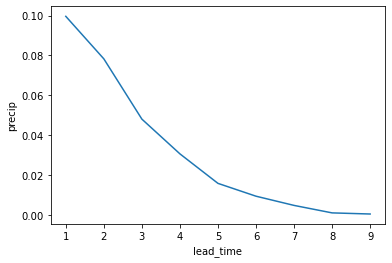

In [63]:
p['precip'].plot()

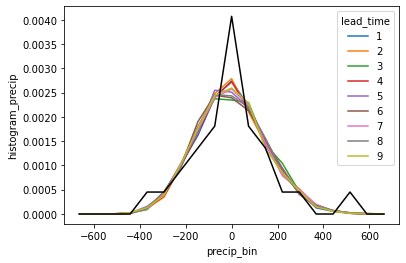

In [17]:
bins = np.linspace(-700,700,20)

fcst_pdf = xhist(fcst_super['precip'], bins=[bins], dim=['sample'], density=True)
obsv_pdf = xhist(obsv_super['precip'], bins=[bins], dim=['sample'], density=True)

fcst_pdf.plot.line(x='precip_bin')
obsv_pdf.plot.line(color='k');

# Play space

In [417]:
def sum_min_samples(ds, dim, min_samples):
    """ Return sum only if there are more than min_samples along dim """
    s = ds.sum(dim, skipna=False)
    # Reference to final lead in sample
    if 'lead_time' in ds.coords:
        if dim in ds['lead_time'].dims:
            l = ds['lead_time'].max(dim, skipna=False)
            s = s.assign_coords({'lead_time': l if len(ds[dim]) >= min_samples else np.nan*l})
    return s if len(ds[dim]) >= min_samples else np.nan*s

In [430]:
import pandas as pd

def resample_forecasts_monthly(ds, n_months=12, final_month=12, method='sum'):
    def _resample_forecasts_monthly(data, lead_times, times):
        s = xr.DataArray(
            data, dims=['time'],
            coords={'time': times, 
                    'lead_time': ('time', lead_times)})
        start_time = _resample_start_time(
            min(s.time).dt.year.item(), 
            min(s.time).dt.month.item(),
            n_months, final_month)
        rs = s.sel(
            time=slice(start_time, None)
        ).resample(
            time=f'{n_months}MS', label='left'
        ).map(sum_min_samples, dim='time', min_samples=n_months)
        return rs.values
        
    xr.apply_ufunc(
        _resample_forecasts_monthly,
        ds,
        ds.lead_time,
        ds.time,
        input_core_dims=[["lead_time"], ["lead_time"], ["lead_time"]],
        output_core_dims=[["lead_time"]],
        exclude_dims=set(("lead_time",)),
        vectorize=True,
        dask='parallelized')

In [431]:
def _resample_start_time(min_year, min_month, n_months, final_month):
    """ Return start time required to have resample fall on correct dates"""
    pivot_month = (final_month - (n_months-1)) % 12
    if pivot_month == 0:
        pivot_month = 12
    return f'{min_year}-{pivot_month:02d}' if min_month <= pivot_month else f'{min_year+1}-{pivot_month:02d}'